In [3]:
"""
MekongWatch: Dual-Polarization Analysis (VV + VH)
=================================================
Detecting flooded vegetation beyond open water surfaces.

Key Innovation: Using VV+VH to identify agricultural flooding hidden 
beneath rice paddies and forest canopy - invisible to VV-only analysis.

Author: MekongWatch Team
NASA Space Apps Challenge 2025
"""

# Cell 1: Setup
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Initialize Earth Engine
try:
    ee.Initialize(project='nasa-flood')  # 본인 프로젝트 ID
except:
    ee.Authenticate()
    ee.Initialize(project='nasa-flood')

# Study area
aoi = ee.Geometry.Rectangle([104.5, 8.5, 106.8, 11.0])

print("Dual-Polarization Analysis Module")
print("="*70)
print("Objective: Detect flooded vegetation using VV+VH SAR data")
print("Period: 2019 wet season")

Dual-Polarization Analysis Module
Objective: Detect flooded vegetation using VV+VH SAR data
Period: 2019 wet season


In [4]:
# Cell 2: Data Collection (VV + VH)
print("\nCollecting dual-polarization Sentinel-1 data...")

# 2019년 8월 (홍수 피크)
ANALYSIS_DATE = '2019-08-01'
ANALYSIS_END = '2019-08-31'

s1_dual = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(ANALYSIS_DATE, ANALYSIS_END) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select(['VV', 'VH'])

# 이미지 개수 확인
image_count = s1_dual.size().getInfo()
print(f"Available images: {image_count}")

if image_count == 0:
    print("⚠ No dual-pol data available for this period")
    print("Trying alternative date range...")
    ANALYSIS_DATE = '2019-07-01'
    ANALYSIS_END = '2019-09-30'
    s1_dual = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(ANALYSIS_DATE, ANALYSIS_END) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .select(['VV', 'VH'])
    image_count = s1_dual.size().getInfo()
    print(f"Extended search: {image_count} images found")

# Median composite (노이즈 감소)
s1_composite = s1_dual.median().clip(aoi)

vv = s1_composite.select('VV')
vh = s1_composite.select('VH')

print("✓ Dual-polarization data prepared")


Available images: 41
✓ Dual-polarization data prepared


In [5]:
# Cell 3: Water Classification (수정됨)
print("\nClassifying water types...")

# VV와 VH 밴드 추출
vv = s1_composite.select('VV')
vh = s1_composite.select('VH')

# ====================================================================
# 1. Open Water (개방 수면)
# ====================================================================
# VV < -16 dB: 매우 어두움 (specular reflection)
# 물 표면이 평평하여 레이더 신호가 반사되지 않고 빠져나감
open_water = vv.lt(-16)

# ====================================================================
# 2. Flooded Vegetation (침수된 식생 - 논밭)
# ====================================================================
# VH < -25 dB: Cross-polarization이 낮음 (물 표면)
# AND
# -16 < VV < -10 dB: VV가 중간 값 (이중 반사)
# 
# 이중 반사 메커니즘:
# - 레이더 신호가 물 표면 → 벼 줄기 → 다시 센서로 반사
# - VV는 물만 있을 때보다 높지만, 마른 땅보다는 낮음
# - VH는 물 표면 때문에 여전히 낮음
flooded_veg = vh.lt(-25).And(vv.gt(-16).And(vv.lt(-10)))

# ====================================================================
# 3. Total Inundation (전체 침수 지역)
# ====================================================================
total_water = open_water.Or(flooded_veg)

# 결과 확인
print("✓ Classification complete")
print("\nThresholds applied:")
print("  - Open Water: VV < -16 dB")
print("  - Flooded Vegetation: (VH < -25 dB) AND (-16 < VV < -10 dB)")
print("\nPhysical interpretation:")
print("  - Open Water: Specular reflection from smooth water surface")
print("  - Flooded Vegetation: Double-bounce scattering (water + plant stems)")


Classifying water types...
✓ Classification complete

Thresholds applied:
  - Open Water: VV < -16 dB
  - Flooded Vegetation: (VH < -25 dB) AND (-16 < VV < -10 dB)

Physical interpretation:
  - Open Water: Specular reflection from smooth water surface
  - Flooded Vegetation: Double-bounce scattering (water + plant stems)


In [6]:
# Cell 4: Area Calculation
def calculate_area(image, geometry):
    """Calculate area in km²"""
    area = image.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,
        maxPixels=1e12,
        tileScale=4
    )
    # VV 또는 VH 중 존재하는 밴드 사용
    band_name = image.bandNames().get(0).getInfo()
    return ee.Number(area.get(band_name)).divide(1e6).getInfo()

print("\nCalculating areas...")

area_open = calculate_area(open_water.selfMask(), aoi)
area_veg = calculate_area(flooded_veg.selfMask(), aoi)
area_total = calculate_area(total_water.selfMask(), aoi)

print(f"\nWater Classification Results:")
print(f"  Open Water: {area_open:,.2f} km²")
print(f"  Flooded Vegetation: {area_veg:,.2f} km²")
print(f"  Total Inundation: {area_total:,.2f} km²")
print(f"\n  Hidden Damage: {(area_veg / area_open * 100):.1f}% additional area")
print(f"  (Invisible to VV-only analysis)")


Calculating areas...

Water Classification Results:
  Open Water: 21,592.99 km²
  Flooded Vegetation: 6,173.35 km²
  Total Inundation: 27,766.34 km²

  Hidden Damage: 28.6% additional area
  (Invisible to VV-only analysis)


In [7]:
# Cell 5: Save Results
print("\nSaving results...")

# CSV 저장
df_dual_pol = pd.DataFrame({
    'category': ['Open Water', 'Flooded Vegetation', 'Total Inundation'],
    'area_km2': [area_open, area_veg, area_total],
    'percentage': [
        (area_open / area_total * 100),
        (area_veg / area_total * 100),
        100.0
    ]
})

output_path = '../data/processed/dual_pol_2019.csv'
df_dual_pol.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")

# Metadata 저장
dual_pol_stats = {
    "analysis_date": f"{ANALYSIS_DATE} to {ANALYSIS_END}",
    "open_water_km2": float(area_open),
    "flooded_vegetation_km2": float(area_veg),
    "total_inundation_km2": float(area_total),
    "hidden_damage_percent": float(area_veg / area_open * 100),
    "method": "VV+VH dual-polarization SAR",
    "thresholds": {
        "open_water_vv": -16,
        "flooded_veg_vv": -12,
        "flooded_veg_vh": -18
    }
}

with open('../data/metadata/dual_pol_2019_stats.json', 'w') as f:
    json.dump(dual_pol_stats, f, indent=2)

print("✓ Metadata saved")


Saving results...
✓ Saved: ../data/processed/dual_pol_2019.csv
✓ Metadata saved



Generating comparison chart...


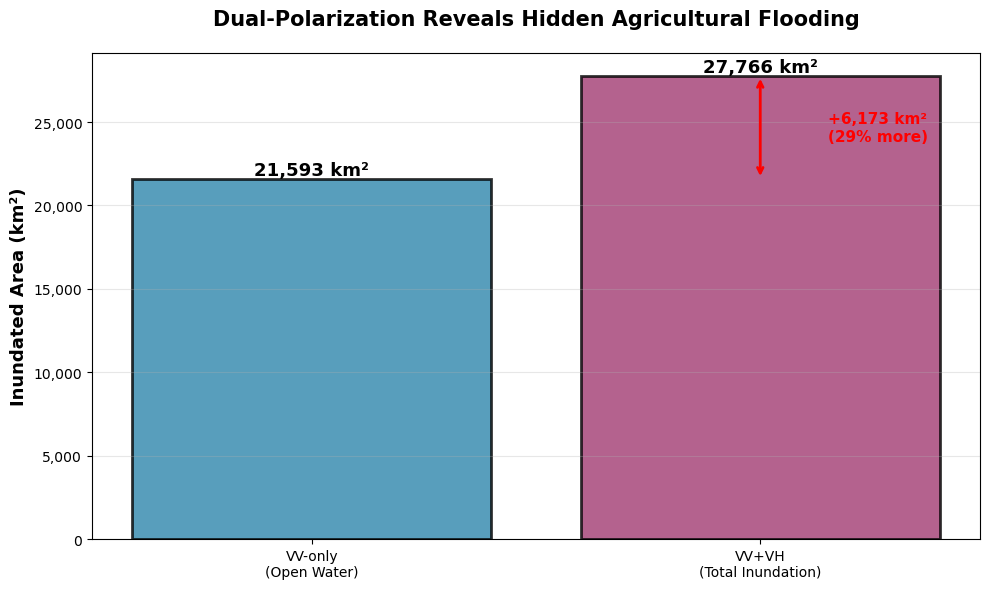

✓ Chart saved


In [8]:
# Cell 6: Visualization - Comparison Chart
print("\nGenerating comparison chart...")

fig, ax = plt.subplots(figsize=(10, 6))

categories = ['VV-only\n(Open Water)', 'VV+VH\n(Total Inundation)']
values = [area_open, area_total]
colors = ['#2E86AB', '#A23B72']

bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# 값 표시
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,.0f} km²',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Hidden damage 표시
ax.annotate('', xy=(1, area_open), xytext=(1, area_total),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(1.15, (area_open + area_total) / 2, 
        f'+{area_veg:,.0f} km²\n({(area_veg/area_open*100):.0f}% more)',
        fontsize=11, color='red', fontweight='bold',
        verticalalignment='center')

ax.set_ylabel('Inundated Area (km²)', fontsize=13, fontweight='bold')
ax.set_title('Dual-Polarization Reveals Hidden Agricultural Flooding', 
             fontsize=15, fontweight='bold', pad=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../streamlit_app/assets/images/dual_pol_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved")

In [9]:
# Cell 7: Interactive Map Export
print("\nGenerating interactive map...")

output_dir = '../streamlit_app/assets/images/maps'
os.makedirs(output_dir, exist_ok=True)

Map = geemap.Map(center=[10.0, 105.5], zoom=8, height='600px')
Map.add_basemap('SATELLITE')

# Layer 1: Open Water (파란색)
Map.addLayer(open_water.selfMask(), 
             {'palette': 'blue'}, 
             'Open Water (VV < -16dB)')

# Layer 2: Flooded Vegetation (노란색)
Map.addLayer(flooded_veg.selfMask(), 
             {'palette': 'yellow', 'opacity': 0.7}, 
             'Flooded Vegetation (VV+VH)')

# Layer 3: AOI
Map.addLayer(ee.FeatureCollection([ee.Feature(aoi)]), 
             {'color': 'red'}, 
             'Study Area')

# HTML 저장
html_path = os.path.join(output_dir, 'dual_polarization_2019.html')
Map.to_html(html_path)
print(f"✓ Map saved: {html_path}")


Generating interactive map...
✓ Map saved: ../streamlit_app/assets/images/maps\dual_polarization_2019.html


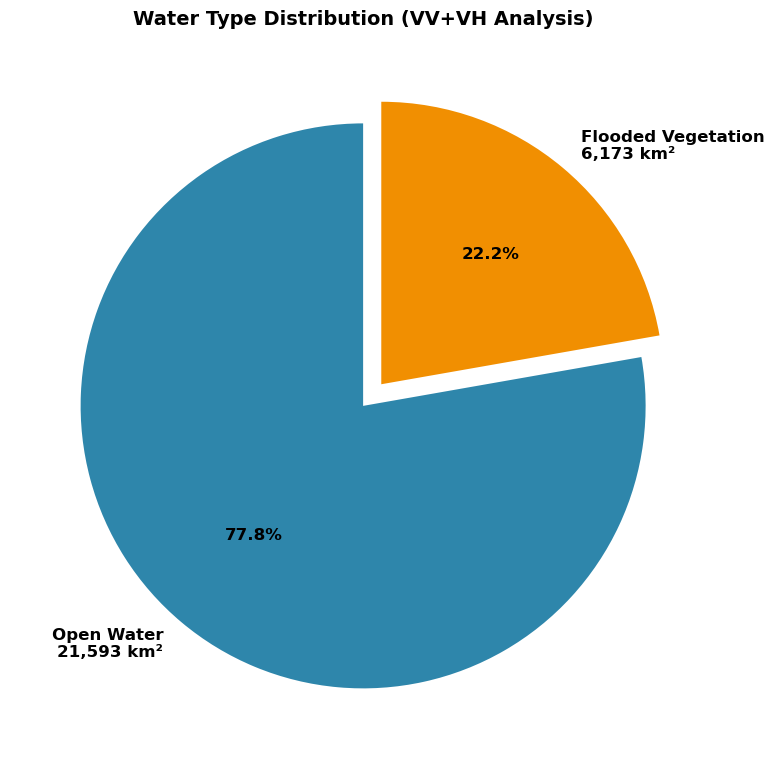

✓ Pie chart saved


In [10]:
# Cell 8: Pie Chart - Water Type Distribution
fig, ax = plt.subplots(figsize=(8, 8))

sizes = [area_open, area_veg]
labels = [f'Open Water\n{area_open:,.0f} km²', 
          f'Flooded Vegetation\n{area_veg:,.0f} km²']
colors = ['#2E86AB', '#F18F01']
explode = (0, 0.1)  # Flooded veg 강조

ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

ax.set_title('Water Type Distribution (VV+VH Analysis)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../streamlit_app/assets/images/dual_pol_pie.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Pie chart saved")

In [11]:
# Cell 9: Summary
print("\n" + "="*70)
print("DUAL-POLARIZATION ANALYSIS COMPLETE")
print("="*70)

print(f"\nKey Findings:")
print(f"  • VV-only detection: {area_open:,.0f} km² (traditional method)")
print(f"  • VV+VH detection: {area_total:,.0f} km² (our method)")
print(f"  • Hidden agricultural damage: {area_veg:,.0f} km²")
print(f"  • Improvement: {(area_veg/area_open*100):.1f}% more area detected")

print(f"\nImplications:")
print(f"  → Rice paddies and forests beneath flood water remain invisible to VV-only SAR")
print(f"  → Dual-polarization reveals true extent of agricultural impact")
print(f"  → Critical for accurate damage assessment and aid distribution")

print(f"\nGenerated Files:")
print(f"  1. dual_pol_2019.csv")
print(f"  2. dual_pol_2019_stats.json")
print(f"  3. dual_pol_comparison.png")
print(f"  4. dual_pol_pie.png")
print(f"  5. dual_polarization_2019.html")

print(f"\n✓ Ready for Streamlit integration")


DUAL-POLARIZATION ANALYSIS COMPLETE

Key Findings:
  • VV-only detection: 21,593 km² (traditional method)
  • VV+VH detection: 27,766 km² (our method)
  • Hidden agricultural damage: 6,173 km²
  • Improvement: 28.6% more area detected

Implications:
  → Rice paddies and forests beneath flood water remain invisible to VV-only SAR
  → Dual-polarization reveals true extent of agricultural impact
  → Critical for accurate damage assessment and aid distribution

Generated Files:
  1. dual_pol_2019.csv
  2. dual_pol_2019_stats.json
  3. dual_pol_comparison.png
  4. dual_pol_pie.png
  5. dual_polarization_2019.html

✓ Ready for Streamlit integration
